# Testing consequence of reponse for correlations <a class="tocSkip"></a>

We start by importing our random number generator and set a global variable 

In [1]:
from numpy.random import default_rng 

rnd = default_rng()

## Generation of pseudorapidity observations 
### `normal_y`

Next is a function to sample a normal distribution to generate rapidities 

$$y\sim\mathcal{N}[0,\sigma]\quad.$$ 

We can specify the number samples, the width of the distribtion $\sigma$, and the random number generator. 

In [2]:
def normal_y(size,sigma=4,rnd=rnd):
    '''Generate `size` rapidities, normal distributed
    around 0 with a standard deviation of `sigma` 
    
    Parameters
    ---------- 
    size : int 
        Number of particles to generate 
    rnd : numpy.random.Generator 
        Generator of random numbers 
    sigma : float
        Standard deviation 
        
    Returns 
    -------
    y : numpy.ndarray 
        Array of size `size` of rapidities 
    '''
    return rnd.normal(0,sigma,size=size)

We test this function by making a sample and histogramming that sample.  We overlay that plot with our PDF scaled to the appropriate integral of the sample 

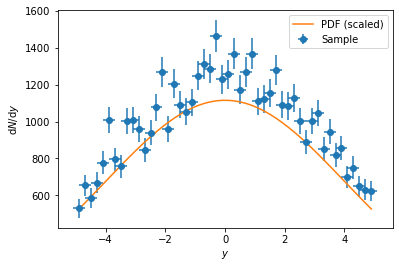

In [3]:
def test_normal_y(size=10000,sigma=4):
    from nbi_stat import histogram
    from numpy import linspace
    from matplotlib.pyplot import gca 
    from scipy.stats import norm
    
    left, right = -5, 5
    sample = normal_y(size=size,sigma=sigma)
    dndy, y, dy, edndy = histogram(sample,linspace(left,right,51))
    
    ax = gca()
    ax.errorbar(y,dndy,edndy,dy,fmt='o',label='Sample')
    
    scale = (dndy*dy).sum()/norm.cdf(right,0,sigma)-norm.cdf(left,0,sigma)
    ax.plot(y,scale*norm.pdf(y,0,sigma),label='PDF (scaled)')
    ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}y$')
    ax.set_xlabel('$y$')
    ax.legend();
    
    return sample 
    
ysample = test_normal_y()

### `y_to_eta`
The next function turns our generated rapidities, $y$, into pseudorapidities, $\eta$, via the relation 

$$t = \tanh y = \frac{\cos\vartheta}{a^2\sin^2\vartheta + 1}\quad,$$ 

which solving for $\tan\theta$ 

$$\tan\frac\vartheta2 = -\frac{(1+a^2)t^2-2\sqrt{a^2+1}\sqrt{a^2t^2+1}+1}{t^2 - 1}\quad,$$

and we calculate 

$$\eta = -\frac12\log\tan\frac\vartheta2\quad.$$

In [4]:
def y_to_eta(y,a=1/2):
    '''Calculate pseudorapidity from rapidity'''
    from numpy import tanh, sqrt, log 
    
    a2    = a**2
    t     = tanh(y)
    t2    = t**2
    tanth = -((1+2*a2)*t2 - 2*t*sqrt(a2+1)*sqrt(a2*t2+1)+1) / (t2-1)
    
    return -log(tanth[tanth>0])/2

We again test our conversion to pseudorapidity by generating a rapidity sample and histogram the resulting pseudorapidity distribution

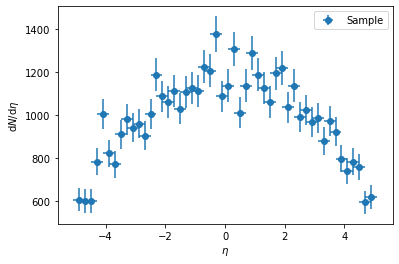

In [5]:
def test_y_to_eta(ysample,a=1/2):
    from nbi_stat import histogram
    from numpy import linspace
    from matplotlib.pyplot import gca 
    from scipy.stats import norm
    
    left, right = -5, 5
    sample = y_to_eta(ysample,a=a)
    dndeta, eta, deta, edndeta = histogram(sample,linspace(left,right,51))
    
    ax = gca()
    ax.errorbar(eta,dndeta,edndeta,deta,fmt='o',label='Sample')
    
    ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\eta$')
    ax.set_xlabel(r'$\eta$')
    ax.legend();
    
    return sample
    
etasample = test_y_to_eta(ysample)

### `normal_y_eta`
We want to be a bit general in the following, so we define a function that will generate pseudorapidities for us using the above.  Note, we can in principle define another, similar, function that will generate pseudorapidites in some other way

In [6]:
def normal_y_eta(size,a=1/2,sigma=4,rnd=rnd):
    return y_to_eta(normal_y(size,sigma=sigma,rnd=rnd),a=a)

## Simulating detector response 

### `smear`
Next, we need to be able to simulate the "response" of a detector.  That is, for each observation of pseudorapidity $\eta_i$ we want to get a corresponding reponse (or weight) $w_i$.  In general, we form the response by 

$$w_i = 1 + f(\eta_i)\quad,$$ 

where $f$ is some function, dependent on $\eta$, that encodes the response.  The function $f$ should be _randomised_ in the sense that it should sample some distribution (possibly depending on $\eta$).  This will introduce an inherient fluctuation in the response of the detector. 

In [7]:
def smear(eta,smear):
    '''Calculates weight of each pseudorapidy as 
    
        1 + f(eta)
        
    where f is some randomized function
    '''
    from numpy import ones_like 
    
    return ones_like(eta) + smear(eta)

### `piecewise`
We define a reponse function which is linear _piecewise_.  That is, 

$$ f(\eta) = \begin{cases}
  a_1 \eta + b_1 & \eta\in A_1=[l_1,h_i]\\
  \vdots & \vdots \\
  a_n \eta + b_n & \eta\in A_n=[l_n,h_n]\\
  0 & \mathrm{otherwise}
  \end{cases}\quad.$$ 
  
We can define as many regions as we like - we just have to make sure to give the parameters for each region.  The regions should in principle be disjoint, but can in practise overlap.

In [8]:
def piecewise(eta,
              a=[1,-1,-.8],
              b=[.5,2,1.8],
              r=[[-3.5,-1.8],
                 [ 1.8, 3.0],
                 [ 3.0, 5.0]]):
    '''A piecewise defined response 
    
    In each region, the reponse is linear 
    
        f = a * eta + b 
        
    The regions are defined as (min,max) of eta 
    
    Parameters
    ---------- 
    eta : numpy.ndarray 
        Where to evaluate 
    a : sequence 
        Slopes in each region 
    b : sequence 
        Offset in each region
    r : sequence of pairs 
        Region definitions as (min,max)
        
    Returns
    -------
    reponse : numpy.ndarray
        The mean response at each eta 
    '''
    from numpy import logical_and, asarray, newaxis, sum
    r = asarray(r)
    eta = eta[:,newaxis]
    
    return sum(logical_and(eta>r[:,0],eta<=r[:,1])*(a*(eta-r[:,0])+b),axis=1)

We run a test of our piecewise response function where the slopes, offsets, and regions roughly correspond to the ALICE FMD parameters. 

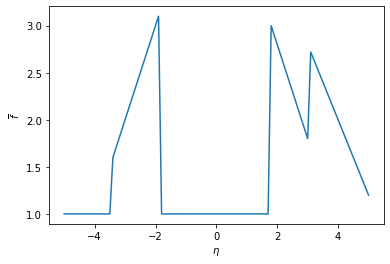

In [9]:
def test_piecewise():
    from numpy import linspace 
    from matplotlib.pyplot import gca 
    
    ax  = gca()
    eta = linspace(-5,5,101)
    f   = smear(eta,piecewise)
    
    ax.plot(eta,f)
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel(r'$\overline{f}$')
    
    return eta
    
etasample = test_piecewise()

### `normal_smear`

The above `piecewise` response does not introduce any randomness into the response.  We can, however, use it to form the mean of some distribution.  We use that to define a function that will smear our response by a normal distribution.  The function depends on another function ($g$, argument `mean`) which evaluated at $\eta$ should return an appropriate mean of a normal distribtion.   Thus, this function will calculate 

$$ f(\eta;g,\sigma) = g(\eta)\left[1+\sigma r\right]\qquad r\sim\mathcal{N}[0,1]\quad.$$ 

Thus, the parameter $\sigma$ is the relative (to the mean $g(\eta)$) standard deviation of the normal distribution.   As mentioned above, the argument `mean` can be any function of pseudorapidity that returns the mean of the distribution to sample. 

It is important to note, that this is just _one_ example of a smearing function.  One could equally well define a function that would introduce Poisson-like smearing 

$$ f(\eta;g,\beta) = r \qquad r\sim\Gamma[g(\eta),\beta]\quad.$$

In [10]:
def normal_smear(eta,mean,rnd=rnd,sigma=.1):
    '''Use a mean reponse to sample with a normal 
    distribution  
    
    Parameters
    ----------
    eta : numpy.ndarray 
        Where to sample 
    mean : callable 
        Function that evaluates the mean at each eta 
    rnd : numpy.random.Generator 
        Random number generator 
    sigma : float 
        (Relative) standard deviation of response 
        
    Returns
    -------
    reponse : numpy.ndarray 
        Randomized reponse 
    '''
    a = mean(eta)
    return a*(1+sigma*rnd.normal(size=len(a)))

We test this normal smearing function together with our piecewise mean response function, again with parameters vaguely reminiscent of for those of the ALICE FMD.  

Note the use of `functools.partial` to bind arguments of some function (e.g., we define `pw` to be a function that calls `piecewise` with specific slope, interscept, and region limit parameters).  This is very hand because it means we do not have to pass arguments down through the call-stack (when `smear` calls `normal_smear` it does not need to pass on the parameter `sigma`, and likewise `normal_smear` need not pass on the slopes, intercepts, and region boundaries to `piecewise`). 

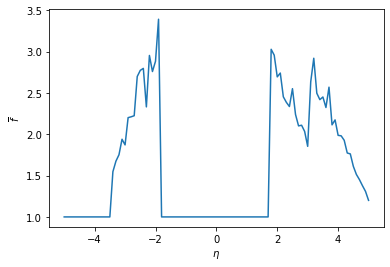

In [11]:
def test_normal_smear(eta):
    from numpy import linspace 
    from matplotlib.pyplot import gca 
    from functools import partial 
    
    pw = partial(piecewise,
                 a=[1,-1,-.8],
                 b=[.5,2,1.8],
                 r=[[-3.5,-1.8],
                    [ 1.8, 3.0],
                    [ 3.0, 5.0]])
    sm = partial(normal_smear,mean=pw)
    
    ax  = gca()
    f   = smear(eta,sm)
    
    ax.plot(eta,f)
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel(r'$\overline{f}$')
    
    return f 

resp = test_normal_smear(etasample)

### `normal_piecewise` 

Note, how this reponse is actually also valid outside the defined regions: Where we did not introduce an explicit smearing, the response is unity - corresponding to the (almost) perfect detector - appropriate for for example the ALICE TPC. 

Before we go in, we will make our "standard" reponse function which uses the above. 

In [12]:
def normal_piecewise(eta,a=[1,-1,-.8],
                       b=[.5,2,1.8],
                       r=[[-3.5,-1.8],
                          [ 1.8, 3.0],
                          [ 3.0, 5.0]],
                       sigma=.1,
                       rnd=rnd):
    from functools import partial 
    
    p = partial(piecewise, a=a, b=b, r=r)
    return normal_smear(eta,mean=p,sigma=sigma,rnd=rnd)

Above, we tested the normal smearing for distinct values of $\eta$.  Now, we want to have several samples of the same pseudorapidity so that we can see how we get different (random) responses each time.    We plot our random smear as a "violin" plot which gives us an idea of the random response distribution. 

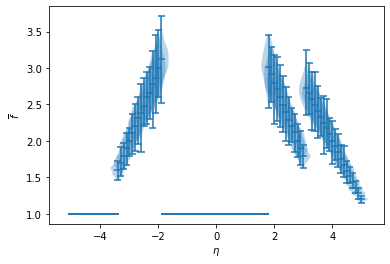

In [13]:
def test_normal_smear_rnd(eta):
    from numpy import linspace, repeat, newaxis 
    from matplotlib.pyplot import gca 
    
    ax   = gca()
    reta = repeat(eta[newaxis,:],100,axis=0)
    f    = smear(reta.ravel(),normal_piecewise)
    
    ax.violinplot(f.reshape(reta.shape),positions=eta,
                  showmeans=True,
                  showmedians=False,
                  showextrema=True)
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel(r'$\overline{f}$')
    
    return f
    
resp = test_normal_smear_rnd(etasample)

## Generation of events and sub-events

### `gen_event`

Next up, we can formulate a function to generate an event.  An "event" in this context is some pseudorapidity observations $\eta_i$ and associated reponses $w_i$ 

$$ e_i = \left\{(\eta_i,w_i)\,\middle|\,i=1,\ldots,n\right\}\quad.$$ 

Our function will take the number of particles to generate $n$, the randomised response function, and the shape parameter $a$ for the $y\rightarrow\eta$ conversion, and the width $\sigma$ of the $\mathrm{d}N/\mathrm{d}y$ distribution. 

In [14]:
def gen_event(size,response=normal_piecewise,gen=normal_y_eta):
    '''Generate a single event of specified size
    
    Parameters
    ----------
    size : int 
        Number of particles to generate 
    reponse : callable 
        Response function 
    
    Returns 
    ------- 
    eta : numpy.ndarray 
        Pseudorapidities 
    resp : numpy.ndarray 
        Response at each pseudorapidity 
    '''
    
    eta  = gen(size=size)
    resp = smear(eta,response)
    
    return eta, resp

We test this routine by generating a single event and then draw $(\eta_i,w_i)$.  Again, our response is similar to the ALICE FMD and TPC responses. 

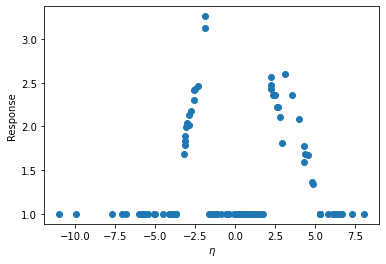

In [15]:
def test_gen_event(size=100):
    from functools import partial
    from matplotlib.pyplot import gca 
    
    eta,resp = gen_event(size)
    
    ax = gca()
    ax.scatter(eta,resp)
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('Response')
        
    return eta,resp

eta, resp = test_gen_event();

### `split_event`

We want to correlated observations of $\eta$ between different regions of the phase-space.  We therefore need to have function that can split our event into different sub-events.   The function below will calculate 

$$f(\eta;l_i,h_i) = \begin{cases}
  (\eta,w) & l_i < \eta < h_i\\
  & \mathrm{otherwise}
  \end{cases}\quad.$$ 
  
That is, after applying this function, we will have 

$$\left\{\begin{array}{c}
  \left\{(\eta_i,w_i)\,\middle|\,l_1<\eta<h_1\right\}\\
  \vdots\\
  \left\{(\eta_i,w_i)\,\middle|\,l_m<\eta<h_m\right\}\\
  \end{array}\right\}\quad,$$
  
that is, we split the event into $m$ sub-events. 

In [16]:
def split_event(eta,resp,r=[[-3.5,-1.8],
                            [-0.8, 0.8],
                            [ 1.8, 5.0]]):
    '''Split event (pseudorapidities and responses) into regions.
    
    The argument `r` defines the regions (in pseudorapidity) to
    split the event into.  The function returns a list of 
    pairs of pseudorapidity and response - one element per region. 
    
    Parameters
    ---------- 
    eta : numpy.ndarray 
        Pseudorapidities 
    resp : numpy.ndarray 
        Responses 
    r : sequence of (float,float)
        A list of regions, one per row of min,max 
        pseudorapidity per region 
        
    Returns
    ------- 
    regions : list of (sequence,sequence)
        A list of pseudorapidites and sequences in each region 
    '''
    from numpy import logical_and, newaxis, asarray, vstack
    r    = asarray(r)
    eta2 = eta[:,newaxis]
    sel  = logical_and(eta2>r[:,0],eta2<=r[:,1])
    
    return [vstack((eta[s],resp[s])) for s in sel.T]

As usual, we test our function.  We split the event into three sub-events - again relevant to the simulation of the ALICE FMD and TPC

$$\begin{align*}
  C &= [-3.5;-1.8]\\
  B &= [-0.8;\phantom{-}0.8]\\
  A &= [\phantom{-}1.8;\phantom{-}5\phantom{.0}]
  \end{align*}\quad,$$
  
and draw each sub-event with a different colour. 

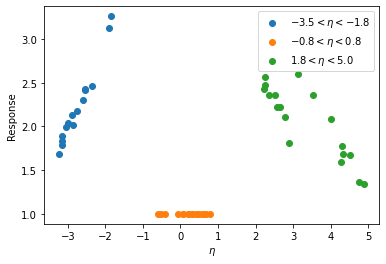

In [17]:
def test_split(eta,resp):
    
    cut = [[-3.5,-1.8],
           [-0.8, 0.8],
           [ 1.8, 5.0]]
    reg = split_event(eta,resp,cut)
    
    from matplotlib.pyplot import gca 
        
    ax = gca()
    
    for r,c in zip(reg,cut):
        ax.scatter(*r,label=fr'${c[0]}<\eta<{c[1]}$')
        
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('Response')
    ax.legend()
        
    return reg
    
c,b,a = test_split(eta,resp)

## Forming the quantities 

### `delta` 

We now want to calculate all distances 

$$\Delta\eta_{ij} = \eta_i - \eta_j\quad,$$ 

between observations in one region to observations in a different region.  That is, the "outer difference" between the vectors of observations in two regions.   We also want to determine the weight of each distance as 

$$W_{ij} = w_i w_j\quad,$$ 

that is the outer product of response vectors in two regions.  We define a simple function that calculates these two matrixes. 

In [18]:
def delta(lhs,rhs):
    '''Calculates all differences in pseudorapidity 
    between the two regions `lhs` and `rhs`
    
        d_ij = l_i - r_j 
        
    and the weight 
    
        w_ij = l_i * r_j 
        
    Parameters
    ---------- 
    lhs : numpy.ndarray (2,n)
        Left-hand side region 
    rhs : numpy.ndarray (2,m)
        Right-hand side region 
        
    Returns
    -------
    d : numpy.ndarray (n,m)
        Distance in pseudorapidity 
    w : numpy.ndarray (n,m)
        Weight of each distance
    '''
    from numpy import newaxis
    d = lhs[0][:,newaxis] - rhs[0]
    w = lhs[1][:,newaxis] * rhs[1]
    
    return d, w

As we are want, we define a test of this.  We use ALICE as our model and calculate the distances and weights of observations in $A$ (FMD1+2) and $C$ (FMD3) to $B$ (TPC).  We plot these two separately. 

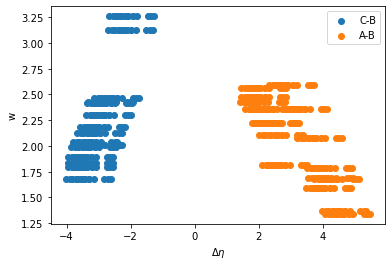

In [19]:
def test_delta(lhs,rhs,ax=None,label=''):
    d, w = delta(lhs,rhs)
    
    from matplotlib.pyplot import gca 
    
    lg = ax is not None
    ax = gca() if ax is None else ax
    
    ax.scatter(d.ravel(),w.ravel(),label=label)
    ax.set_xlabel(r'$\Delta\eta$')
    ax.set_ylabel(r'w')
    
    if lg:
        ax.legend()
        
    return ax, d, w
    
ax,*cb = test_delta(c,b,None,label='C-B')
ax,*ab = test_delta(a,b,ax,  label='A-B')

Because we didn't generate too many particles, we can clearly see the grouping with observations in $A$ and $C$. 

### `all_delta` 

Above, we calculated the distances of the regions $A$ and $C$ to $B$.   However, we can generalise that a bit.  We define a function that takes two arguments - the region(s) we want to measure to and the regions we want to measure from.  We then calculate all distances from the source region(s) ($B$ above) to the destination regions ($A$ and $C$ above) and return a single vector of the distances and their weights. 

In [20]:
def all_delta(src,dst):
    if not type(src) in [list,tuple]:
        src = [src] 
        
    if not type(dst) in [list,tuple]:
        dst = [dst]
        
    def unr(d,w):
        from numpy import vstack 
        return vstack((d.ravel(), w.ravel()))
    
    from numpy import hstack
    t = hstack([unr(*delta(d,s)) for d in dst for s in src])
    
    return t[0],t[1]       

We test this on the regions defined above.  We pass $B$ for the source and $A,C$ for the destinations.  We can compare the resulting plot to the plot above to validate that we see the same thing. 

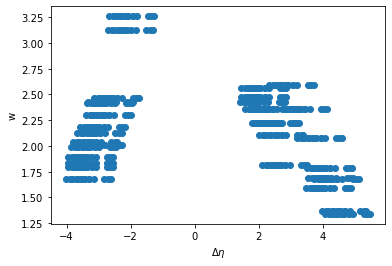

In [21]:
def test_all_delta(src=b,dst=(a,c)):
    d, w = all_delta(src,dst)
    
    from matplotlib.pyplot import gca 
    
    ax = gca()
    
    ax.scatter(d,w)
    ax.set_xlabel(r'$\Delta\eta$')
    ax.set_ylabel(r'w')
    
    return d, w
    
all_d, all_w = test_all_delta()

### `sum_distances` 

We almost have all the pieces we need for our simulation.  The next step is to do the per-event analysis.   First thing is to take all our observations $(\Delta_{ij},W_{ij})$ and sum in bins of $\Delta\eta$

In [22]:
def sum_distances(delta,w,bins):
    from numpy import histogram 
    sumw, _ = histogram(delta,bins,weights=w)
    return sumw 

We apply this to the distances and weights we calculated above and show the resulting (per-event) histogram 

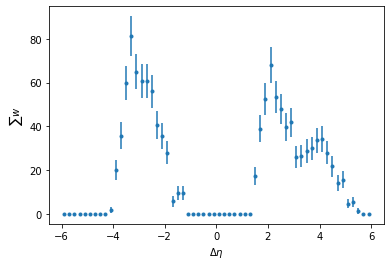

In [23]:
def test_sum_distances(delta=all_d,weights=all_w):
    from numpy import linspace, sqrt
    from matplotlib.pyplot import gca 
    
    ax = gca()
    
    bins = linspace(-6,6,61)
    sumw = sum_distances(delta,weights,bins)
    
    x    = (bins[1:]+bins[:-1])/2 
    e    = sqrt(sumw)
    
    ax.errorbar(x,sumw,e,fmt='.')
    ax.set_xlabel(r'$\Delta\eta$')
    ax.set_ylabel(r'$\sum w$')
    
    return sumw
    
test_sum_distances();

## The analysis 

Thus, summing the weights of the binned distances over many events will give us the signal correlation. However, we also want to make the mixed correlation.  Fortunately, we can reuse the function `sum_distances` - all we need to do is mix the distances (and weights) between different events.  That will be our next focus. 

One word of caution though:  Up until now, we the code we have written is agnostic to the specifics of our simulation.   We can in prinicple generate our pseudorapidity observations in a different way.  Above we defined our function `gen_event` which takes the argument _gen_ to generate the pseudorapidities.  By default we will use the function `normal_y_eta` as defined above, but we could use something different.  Likewise, we defaulted the reponse to be normal smearing around a piecewise mean reponse, but again - we could plug in a different response.  When we split the event into sub-events, we have made no presumptions about the regions we wHant to split into - the number of regions or the size of them - we could chose to have more of fewer regions if we wanted to, it all depends on the arguments we pass to the functions. 

However, this is about to change.  In the following, we will sometimes need to assume specifics, for example how many regions we have, and how to correlate them.  We will try to be as generic as possible as it will leave us with many more options and avenues to persue.  On the other hand, we do not want to make the code too clunky to work with, so we must accept some loss of generality (even though it will be with a bleeding heart). 

### `current_mix` 

Our next function is still pretty general.  Here, we take the current source and destination observation as well as source and destination observations from another event and calculate this events signal contribution as well as the mixed-event background contribution - all in bins of $\Delta\eta$. 

**NB**: Perhaps we also need to calculate a relative weight of the background as 

$$w_B = \frac{N_{\mathrm{this}}}{N_{\mathrm{mix}}}\quad,$$ 

where $N_{\mathrm{this}}$ and $N_{\mathrm{mix}}$ is the number of observations in this and the mixed samples, respectively. 

In [24]:
def current_mix(current_src,current_dst,other_src,other_dst,bins):
    '''Calculate this events contribution to the signal and the mixed events 
    contribution to the background 
    
    Parameters
    ---------- 
    current_src : (numpy.ndarray,numpy.ndarray)
        Pseudorapidities and responses at the source in this event
    current_dst : (numpy.ndarray,numpy.ndarray)
        Pseudorapidities and responses at the destinations in this event
    other_src : (numpy.ndarray,numpy.ndarray)
        Pseudorapidities and responses at the source in other event
    other_dst : (numpy.ndarray,numpy.ndarray)
        Pseudorapidities and responses at the destinations in other event
    bins : numpy.ndarray 
        Delta(eta) bin boundaries
        
    Returns
    -------
    signal : numpy.ndarray 
        This event's contribution to signal 
    background : numpy.ndarray 
        Mixed event's contribtion to background
    '''
    cur_d, cur_w = all_delta(current_src,current_dst)
    
    mix_d1, mix_w1 = all_delta(current_src,other_dst)
    mix_d2, mix_w2 = all_delta(other_src,current_dst)
    
    from numpy import hstack 
    mix_d = hstack((mix_d1,mix_d2))
    mix_w = hstack((mix_w1,mix_w2))
    
    w_mix    = len(cur_d) / len(mix_d)
    sumw_cur = sum_distances(cur_d,cur_w,bins)
    sumw_mix = sum_distances(mix_d,mix_w,bins)
    
    return sumw_cur, sumw_mix, w_mix

We surely want to perform a test on this.  However, so far we only have one event to play with, so we need to generate a new event that we can mix in. 

In [25]:
def test_current_mix(current_src,current_dst):
    from numpy import linspace, sqrt 
    from matplotlib.pyplot import gca 
    
    oc,ob,oa = split_event(*gen_event(100))
    other_src = ob 
    other_dst = (oc,oa)
    
    bins = linspace(-6,6,61)
    
    sig, bkg, wbkg = current_mix(current_src,current_dst,
                                 other_src,other_dst,
                                 bins)
    
    x    = (bins[1:]+bins[:-1])/2 
    esig = sqrt(sig)
    ebkg = sqrt(wbkg*bkg)
    
    ax = gca() 
    
    ax.errorbar(x,sig,esig,fmt='.',label='Signal')
    ax.errorbar(x,wbkg*bkg,ebkg,fmt='.',label='Background')
    ax.set_xlabel(r'$\Delta\eta$')
    ax.set_ylabel(r'$\sum w$')
    ax.legend()
    
    
test_current_mix(b,(c,a))

### `loop` 

It is clear where we need to go from here.   We need to 

- set-up signal and background storage 
- loop over some number events, in which we 
  - get the observations $(\eta_i,w_i)$ 
  - split these into our regions 
  - if we have a candidate for mixing 
    - calculate contributions to signal and background 
    - store this event as candidate for mixing 
- calculate the final correlation function 

However, we would like to compare our results including detector response to the ideal case where all detector responses are the identity.  That means we have to do a bit more 

- set-up signal and background storage for _both_ sub-optimal and ideal cases 
- loop over some number events, in which we 
  - get the observations $(\eta_i,w_i)$ 
  - copy these observations - in particular the reponses, and force all of reponse 
    in this copy to be unity - this will be our ideal sample 
  - split these into our regions - both for sub-optimal and ideal cases 
  - if we have a candidate for mixing 
    - calculate contributions to signal and background - again, separately for sub-optimal and ideal case 
    - store this event as candidate for mixing - separately for the two cases
- calculate the final correlation function - one for the sub-optimal and one for the ideal case

We code this up in a function.   Note, that we still manage to be relatively general.

In [26]:
def loop(ns,gen,split,src_mask,dst_msk,bins):
    '''Loop over the list `ns` of number of 
    particles to generate in each event and do the analysis
    on the generated particles.  Note, we form an "ideal" event 
    from the generated event (i.e., with no detector effects)
    
    Parameters
    ---------- 
    ns : sequence of int 
        A list of number of particles to generate in each event.  
        The size of this list determines how many events we want
        to generate.
    gen : callable 
        A function to generate a single event.  This must accept 
        the number of particles to generate as it's only argument.
        We can achieve that by using `functools.partial` on 
        `gen_event` to bind the other arguments
    split : callable
        A function that will split an event into separate regions.  
        Again, this function must only accept the $(\eta_i,w_i)$ 
        observations, and we can use `functools.partial` on 
        `split_event` to tie the other arguments.
        
        Note, the number of regions that this splits the event into 
        must match the size of the masks `src_mask` and `dst_mask` 
    src_mask : sequence of bool 
        A mask of regions to consider source regions.  This sequence 
        must be the same length as the regions that `split` splits
        the event into.  Regions for which the corresponding element 
        in this mask are `True` are considered source regions.  
        Note between `src_mask` and `dst_mask` there is no requirement 
        that all regions are selected 
    dst_mask : sequence of bool 
        A mask of regions to consider destination regions.  This sequence 
        must be the same length as the regions that `split` splits
        the event into.  Regions for which the corresponding element 
        in this mask are `True` are considered destination regions.  
        Note between `src_mask` and `dst_mask` there is no requirement 
        that all regions are selected 
    bins : numpy.ndarray 
        Delta(eta) bin boundaries to use 
        
    Returns
    -------
    subop_sig : numpy.ndarray 
        Sum of signals for sub-optimal events
    subop_bkg : numpy.ndarray 
        Sum of backgrounds for sub-optimal events
    ideal_sig : numpy.ndarray 
        Sum of signals for ideal events
    ideal_bkg : numpy.ndarray 
        Sum of backgrounds ideal events
    '''
    from numpy import ones_like, zeros 
    
    ideal_old = None 
    subop_old = None 
    
    nbin      = len(bins)-1 
    ideal_sig = zeros(nbin)
    ideal_bkg = zeros(nbin)
    subop_sig = zeros(nbin)
    subop_bkg = zeros(nbin)
    
    def take(ev):
        reg = split(*ev)
        def take2(reg,mask):
            return [r for r,m in zip(reg,mask) if m]
        
        return take2(reg,src_mask),take2(reg,dst_msk)
    
    for n in ns:
        subop_ev    = gen(n)
        subop_cur   = take(subop_ev)
        
        ideal_ev    = (subop_ev[0],ones_like(subop_ev[1]))
        ideal_cur   = take(ideal_ev)
        
        if ideal_old is None or subop_old is None: 
            ideal_old = ideal_cur
            subop_old = subop_cur
            continue 
            
        subop_s, subop_b, subop_w = current_mix(*subop_cur,*subop_old,bins)
        ideal_s, ideal_b, ideal_w = current_mix(*ideal_cur,*ideal_old,bins)
        
        subop_sig += subop_s 
        subop_bkg += subop_b * subop_w
        ideal_sig += ideal_s
        ideal_bkg += ideal_b * ideal_w 
        ideal_old =  ideal_cur
        subop_old =  subop_cur
        
    return subop_sig, subop_bkg, ideal_sig, ideal_bkg 

We won't do an explict test of this function.  Instead we will code up an explicit simulation. 

### `fixed_simul` 

Below we will be rather explicit about the settings even though we did define sensible defaults above.  One could customise the simulation via an appropriate `dict` to generalise this a bit more 

In [27]:
def fixed_simul(nev=1000):
    from numpy import linspace, zeros
    from numpy.random import default_rng
    from functools import partial
    
    rnd            = default_rng()
    
    y_sigma        = 4 
    eta_a          = 1/2
    gen_eta        = partial(normal_y_eta,
                             a=eta_a,sigma=y_sigma,rnd=rnd)
    
    #                 FMD3        FMD2        FMD1
    resp_reg       = [[-3.5,-1.8],[ 1.8, 3.0],[ 3.0, 5.0]]
    resp_slope     = [1,          -1,          -.8]
    resp_inter     = [.5,         2,           1.8]
    resp_sigma     = .1 
    response       = partial(normal_piecewise,
                             a=resp_slope,b=resp_inter,
                             r=resp_reg,sigma=resp_sigma,
                             rnd=rnd)

    gen_ev         = partial(gen_event,response=response,gen=gen_eta)
    
    #                FMD-A        TPC         FMD-C
    split_reg      = [[-3.5,-1.8],[-0.8, 0.8],[ 1.8, 5.0]]
    split_ev       = partial(split_event,r=split_reg)
    src_mask       = [False,      True,       False]
    dst_msk        = [True,       False,      True]

    delta_eta_bins = linspace(-6,6,61)
    
    sig_sumw       = zeros(len(delta_eta_bins)-1)
    bkg_sumw       = zeros(len(delta_eta_bins)-1)
    
    gen_n          = partial(rnd.poisson,lam=100)
    
    return delta_eta_bins, \
        *loop(gen_n(size=nev),
                    gen_ev,
                    split_ev,
                    src_mask,
                    dst_msk,
                    delta_eta_bins)

Let us run this simulation. 

In [28]:
res = fixed_simul()

### `results`

What we need now is essentially to form the ratio 

$$C = \frac{S}{B}\quad,$$ 

and illustrate it.  We define a simple function for that 

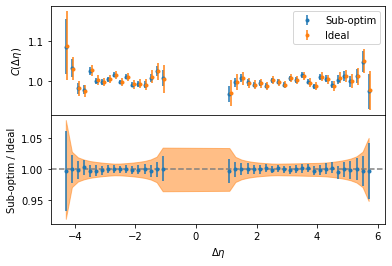

In [29]:
def results(bins,subop_s,subop_b,ideal_s,ideal_b):
    from numpy import sqrt 
    
    x    = (bins[1:]+bins[:-1])/2 
    
    def ratio(s,b,x,o=0):
        s0 = s[b!=0]
        b0 = b[b!=0]
        x0 = x[b!=0]+o
        es = sqrt(s0)
        eb = sqrt(b0)
        r  = s0 / b0 
        er = r * sqrt((es/s0)**2 + (eb/b0)**2)
        
        return x0, r, er 
    
    delta_eta        = (bins[1:]+bins[:-1])/2 
    subop = ratio(subop_s,subop_b,x)
    ideal = ratio(ideal_s,ideal_b,x,.05)
    
    from matplotlib.pyplot import subplots
    
    fig, ax = subplots(nrows=2,sharex=True,gridspec_kw={'hspace':0})
    ax[0].errorbar(*subop,fmt='.',label='Sub-optim')
    ax[0].errorbar(*ideal,fmt='.',label='Ideal')
    ax[0].set_ylabel(r'$C(\Delta\eta)$')
    ax[0].legend()
    
    rat  = subop[1] / ideal[1]
    erat = subop[2] / ideal[1]
    eref = ideal[2] / ideal[1]
    #erat = rat * sqrt((subop[2]/subop[1])**2+(ideal[2]/ideal[1])**2)
    
    ax[1].axhline(1,color='gray',ls='--')
    ax[1].fill_between(subop[0],1-eref,1+eref,alpha=.5,color='C1')
    ax[1].errorbar(subop[0],rat,erat,fmt='.',color='C0')
    ax[1].set_ylabel('Sub-optim / Ideal')
    ax[1].set_xlabel(r'$\Delta\eta$')
    # ax[1].set_ylim(.92,1.08)
    
results(*res)

With this, we're more or less done.   What remains is to play around with parameters and such and see what the effect is. 

### `cfg_simul` 

To make it easier to change settings, we define a function which uses the methods as before, but we get the parameters from a `dict`.  Thus, we can simply copy the default settings and change parameters as need and then call `cfg_simul` with this new `dict` as the `cfg` argument. 

First we define our default settings. 

In [30]:
cfg = {
    'y_sigma': 4,
    'eta_a':   1/2,
    'response': {
        #                 FMD3        FMD2        FMD1
        'regions':   [[-3.5,-1.8],[ 1.8, 3.0],[ 3.0, 5.0]],
        'slopes':    [1,          -1,          -.8],
        'intercepts':[.5,         2,           1.8],
        'sigma':     .1
    },
    'split': {
        #              FMD-A        TPC         FMD-C
        'regions':     [[-3.5,-1.8],[-0.8, 0.8],[ 1.8, 5.0]],
        'sources':     [False,      True,       False],
        'destinations':[True,       False,      True]
    },
    'bins': {
        'n':    60,
        'low':  -6,
        'high': 6
    },
    'n': {
        'lambda': 100
    }
}

Next, the function to run the simulation given a `dict` like the one above. 

In [31]:
def cfg_simul(nev=1000,cfg=cfg):
    from numpy import linspace, zeros
    from numpy.random import default_rng
    from functools import partial
    
    rnd            = default_rng()
    
    y_sigma        = 4 
    eta_a          = 1/2
    gen_eta        = partial(normal_y_eta,
                             a    =cfg['eta_a'],
                             sigma=cfg['y_sigma'],
                             rnd  =rnd)
    
    resp_cfg       = cfg['response']
    response       = partial(normal_piecewise,
                             a=resp_cfg['slopes'],
                             b=resp_cfg['intercepts'],
                             r=resp_cfg['regions'],
                             sigma=resp_cfg['sigma'],
                             rnd=rnd)

    gen_ev         = partial(gen_event,response=response,gen=gen_eta)
    
    split_cfg      = cfg['split']
    split_ev       = partial(split_event,
                             r=split_cfg['regions'])
    src_mask       = split_cfg['sources']
    dst_msk        = split_cfg['destinations']

    bins_cfg       = cfg['bins']
    bins           = linspace(bins_cfg['low'],
                              bins_cfg['high'],
                              bins_cfg['n']+1)
    
    gen_n          = partial(rnd.poisson,lam=cfg['n']['lambda'])
    
    return bins, \
        *loop(gen_n(size=nev),
                    gen_ev,
                    split_ev,
                    src_mask,
                    dst_msk,
                    bins)

Let's run this and pass the result directly to the final analysis function. 

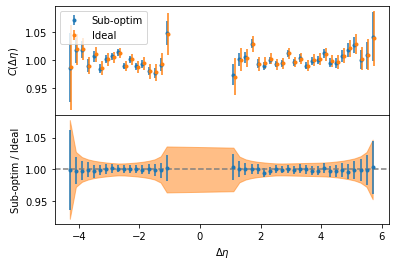

In [32]:
results(*cfg_simul(cfg=cfg))